# 1. Instalação de dependências

In [1]:
!pip install -q scikit-learn pandas joblib

# 2. Imports e configurações iniciais

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score


import joblib

# 3. Função de limpeza de texto

In [3]:
def clean_text(text):
  if not isinstance(text, str):
      return ""
  text = text.lower()
  text = re.sub(r"http\S+|www\S+|@\w+|#", " ", text)
  text = re.sub(r"[^a-záàâãéèêíïóôõöúçñ\s]", " ", text)
  text = re.sub(r"\s+", " ", text).strip()
  return text

# 4. Tratamento de Negações

In [4]:
def handle_negations(text):
  if not isinstance(text, str):
    return ""
  patterns = [
    r"\bnão\s+(\w+)",
    r"\bnao\s+(\w+)",
    r"\bnunca\s+(\w+)",
    r"\bjamais\s+(\w+)"
  ]
  for p in patterns:
      text = re.sub(p, r"nao_\1", text)
  return text

# 5. Tratamento de Intensificadores

In [5]:
def handle_intensifiers(text):
  if not isinstance(text, str):
    return ""
  intensifiers = r"(muito|bem|super|extremamente|bastante|totalmente)"
  text = re.sub(
      rf"\b{intensifiers}\s+(ruim|péssimo|horrível|insatisfeito|decepcionado|bom|ótimo|excelente|confuso)",
      r"\1_\2",
      text
  )
  return text


# 6. Pipeline único de pré-processamento

6.1 Colapsar intensificador + polaridade

In [6]:
def preprocess_text(text):
  text = clean_text(text)
  text = handle_negations(text)
  text = handle_intensifiers(text)
  return text


6.2 Colapso semântico de eventos negativos

In [7]:
# 6.2 Colapso semântico de eventos negativos
def handle_negative_events(text):
    """
    Junta substantivo + evento negativo.
    Ex:
    'entrega atrasou' -> 'entrega_atrasou'
    'caixa amassada'  -> 'caixa_amassada'
    """
    if not isinstance(text, str):
        return ""

    patterns = [
        r"\b(entrega)\s+(atrasou|demorou)",
        r"\b(caixa|produto)\s+(amassada|quebrada|danificada)",
        r"\b(problema)\s+(persistiu|continua)",
    ]

    for p in patterns:
        text = re.sub(p, r"\1_\2", text)

    return text


# 7. Normalização de colunas (fallback)

In [8]:
def normalize_columns(df):
  rename_map = {
    'texto': 'text', 'comentario': 'text', 'comentário': 'text', 'review': 'text',
    'sentimento': 'label', 'classe': 'label', 'rotulo': 'label', 'sentiment': 'label'
  }
  df = df.rename(columns={old: new for old, new in rename_map.items() if old in df.columns})
  if 'text' not in df.columns or 'label' not in df.columns:
      raise ValueError("CSV precisa conter colunas de texto e rótulo")
  return df[['text', 'label']]

# 8. Carregamento do dataset

In [9]:
from google.colab import files
import io


uploaded = files.upload()
filename = list(uploaded.keys())[0]


df = pd.read_csv(
    io.BytesIO(uploaded[filename]),
    sep=",",
    quotechar='"',
    doublequote=True,
    escapechar="\\",
    encoding="utf-8",
    engine="python",
  on_bad_lines="skip"
)


df = normalize_columns(df)
print("Total de registros carregados:", len(df))
display(df.head())


Saving data.csv to data.csv
Total de registros carregados: 3058


,text,label
0,"Produto excelente, chegou rápido e bem embalad...",Positivo
1,"Chegou com defeito, tive que devolver. Péssimo.",Negativo
2,"Entrega no prazo, mas a embalagem veio amassada.",Neutro
3,"Amei demais! Cor perfeita, material ótimo.",Positivo
4,"Demorou 20 dias pra chegar, nunca mais compro ...",Negativo


# 9. Limpeza e pré-processamento dos dados

In [10]:

df['text_clean'] = df['text'].apply(preprocess_text)
df = df[df['text_clean'] != ""]
df['label'] = df['label'].str.strip().str.capitalize()

print(df['label'].value_counts())



label
Negativo    1332
Positivo    1121
Neutro       604
Name: count, dtype: int64


# 10. Divisão treino / teste (ANTES do oversampling)

In [11]:
X = df['text_clean']
y = df['label']


X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y
)

# 11. Oversampling manual apenas no treino

In [12]:
# Oversampling manual apenas no conjunto de treino

train_df = pd.DataFrame({'text': X_train, 'label': y_train})
majority_size = train_df['label'].value_counts().max()


balanced_parts = []
for label in train_df['label'].unique():
  subset = train_df[train_df['label'] == label]
  subset_upsampled = resample(
    subset,
    replace=True,
    n_samples=majority_size,
    random_state=42
  )
  balanced_parts.append(subset_upsampled)


train_balanced = pd.concat(balanced_parts).sample(frac=1, random_state=42)
print("Distribuição após oversampling (treino):")
print(train_balanced['label'].value_counts())

Distribuição após oversampling (treino):
label
Negativo    1065
Neutro      1065
Positivo    1065
Name: count, dtype: int64


# 12. Vetorização TF-IDF

In [13]:
tfidf = TfidfVectorizer(
  ngram_range=(1,2),
  min_df=2,
  max_df=0.9,
  sublinear_tf=True
)


X_train_tfidf = tfidf.fit_transform(train_balanced['text'])
X_test_tfidf = tfidf.transform(X_test)


y_train_bal = train_balanced['label']

# 13. Treinamento dos modelos

In [14]:
lr_model = LogisticRegression(
  max_iter=1000,
  class_weight='balanced',
  C=1.0,
  random_state=42
)


svm_model = LinearSVC(
  class_weight='balanced',
  random_state=42
)


lr_model.fit(X_train_tfidf, y_train_bal)
svm_model.fit(X_train_tfidf, y_train_bal)

LinearSVC(class_weight='balanced', random_state=42)

# 14. Avaliação (métricas confiáveis)

In [15]:
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_svm = svm_model.predict(X_test_tfidf)


print('Acurácia LR:', accuracy_score(y_test, y_pred_lr))
print('Acurácia SVM:', accuracy_score(y_test, y_pred_svm))


print('\nRelatório Regressão Logística:\n')
print(classification_report(y_test, y_pred_lr, digits=4))


print('\nRelatório SVM Linear:\n')
print(classification_report(y_test, y_pred_svm, digits=4))

Acurácia LR: 0.9575163398692811
Acurácia SVM: 0.9656862745098039

Relatório Regressão Logística:

              precision    recall  f1-score   support

    Negativo     0.9621    0.9513    0.9567       267
      Neutro     0.9421    0.9421    0.9421       121
    Positivo     0.9604    0.9732    0.9667       224

    accuracy                         0.9575       612
   macro avg     0.9549    0.9556    0.9552       612
weighted avg     0.9575    0.9575    0.9575       612


Relatório SVM Linear:

              precision    recall  f1-score   support

    Negativo     0.9697    0.9588    0.9642       267
      Neutro     0.9583    0.9504    0.9544       121
    Positivo     0.9649    0.9821    0.9735       224

    accuracy                         0.9657       612
   macro avg     0.9643    0.9638    0.9640       612
weighted avg     0.9657    0.9657    0.9656       612



# 15. Matrizes de confusão

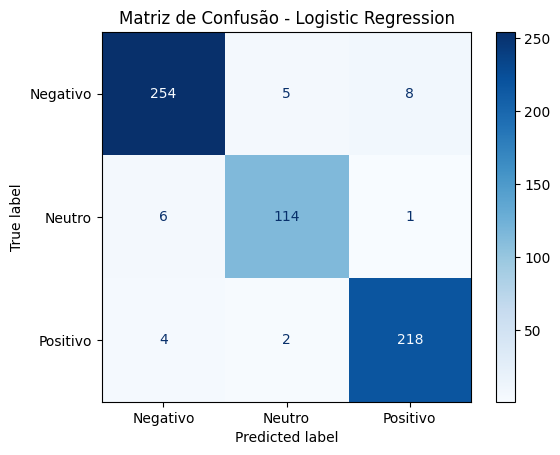

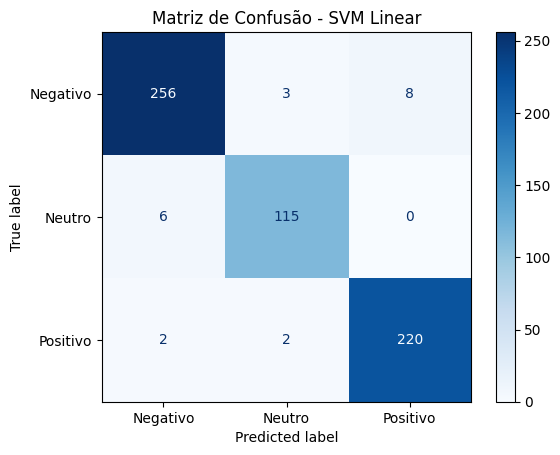

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ===== Matriz de Confusão - Logistic Regression =====
cm_lr = confusion_matrix(
    y_test,
    y_pred_lr,
    labels=lr_model.classes_
)

disp_lr = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr,
    display_labels=lr_model.classes_
)

disp_lr.plot(cmap='Blues')
plt.title('Matriz de Confusão - Logistic Regression')
plt.grid(False)
plt.show()


# ===== Matriz de Confusão - SVM Linear =====
cm_svm = confusion_matrix(
    y_test,
    y_pred_svm,
    labels=svm_model.classes_
)

disp_svm = ConfusionMatrixDisplay(
    confusion_matrix=cm_svm,
    display_labels=svm_model.classes_
)

disp_svm.plot(cmap='Blues')
plt.title('Matriz de Confusão - SVM Linear')
plt.grid(False)
plt.show()


# 16. Comparação gráfica: LR vs SVM

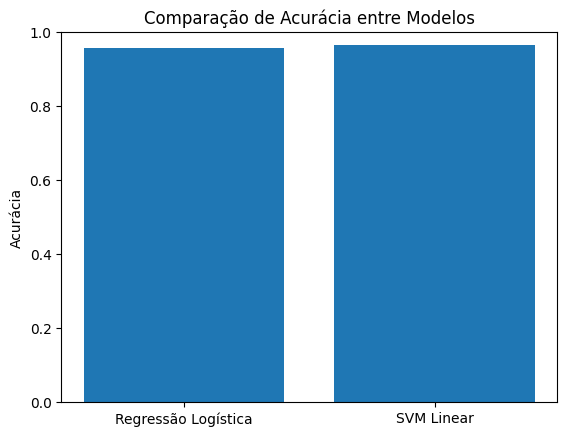

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Predições (garantia contra erro de execução fora de ordem)
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_svm = svm_model.predict(X_test_tfidf)

# Cálculo das acurácias
acc_lr = accuracy_score(y_test, y_pred_lr)
acc_svm = accuracy_score(y_test, y_pred_svm)

# Dados para o gráfico
models = ['Regressão Logística', 'SVM Linear']
accuracy_scores = [acc_lr, acc_svm]

# Gráfico de barras
plt.figure()
plt.bar(models, accuracy_scores)
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.ylim(0, 1)  # padrão para métricas de classificação
plt.show()



# 17. Validação Cruzada Estratificada

In [22]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


lr_cv_scores = cross_val_score(
  lr_model,
  X_train_tfidf,
  y_train_bal,
  cv=skf,
  scoring='f1_macro'
)


svm_cv_scores = cross_val_score(
  svm_model,
  X_train_tfidf,
  y_train_bal,
  cv=skf,
  scoring='f1_macro'
)


print('LR - Média F1:', lr_cv_scores.mean())
print('SVM - Média F1:', svm_cv_scores.mean())

LR - Média F1: 0.9793477552113637
SVM - Média F1: 0.9846693484012441


# 18. Teste prático – frases novas

In [25]:
frases_teste = [
  "Muito insatisfeito  com o atendimento. Não resolveram meu problema.",
  "Não gostei. A cor é muito diferente da foto do anúncio.",
  "Produto fraco, não tancou.",
  "A entrega atrasou demais e a caixa chegou amassada.",
  "Simplesmente fantástico, superou todas as minhas expectativas!",
  "Veio quebrado, quero meu dinheiro de volta imediatamente."
]


frases_proc = [preprocess_text(f) for f in frases_teste]
frases_vec = tfidf.transform(frases_proc)


predicoes = lr_model.predict(frases_vec)
probs = lr_model.predict_proba(frases_vec)


pd.DataFrame({
    'Texto': frases_teste,
    'Predição': predicoes,
    'Confiança': probs.max(axis=1)
})

,Texto,Predição,Confiança
0,Muito insatisfeito com o atendimento. Não res...,Negativo,0.632349
1,Não gostei. A cor é muito diferente da foto do...,Negativo,0.516979
2,"Produto fraco, não tancou.",Negativo,0.877425
3,A entrega atrasou demais e a caixa chegou amas...,Positivo,0.437294
4,"Simplesmente fantástico, superou todas as minh...",Positivo,0.756692
5,"Veio quebrado, quero meu dinheiro de volta ime...",Negativo,0.947138


# 19. Salvando modelos

In [27]:
import os
import joblib

# Criar pasta 'models' se não existir
os.makedirs('models', exist_ok=True)

# Salvar os modelos e o vetor TF-IDF
joblib.dump(lr_model, 'models/modelo_lr_sentimentos.pkl')
joblib.dump(svm_model, 'models/modelo_svm_sentimentos.pkl')
joblib.dump(tfidf, 'models/tfidf.pkl')

print("Tudo pronto para testes com os modelos salvos ✅")

Tudo pronto para testes com os modelos salvos ✅
